<a href="https://colab.research.google.com/github/jamissonfreitas/IN1167/blob/master/ML/ARIMA_and_MLP(gold%20price).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import io
import requests
# lib to plot the data
import matplotlib.pyplot as plt
# lib to use the decompositio in the time series
from statsmodels.tsa.seasonal import seasonal_decompose
# lib to use the acf and pcf correlations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# lib to organize the data in data frame
from pandas import DataFrame
# lib to import the stocastic basic models
from statsmodels.tsa.api import Holt
# lib to import the ar model
from statsmodels.tsa.ar_model import AR

from statsmodels.tsa.arima_model import ARMA, ARIMA

from sklearn.metrics import mean_squared_error

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE

# Constants

In [0]:
H = 6
V = 12



# GOLD CLOSE PRICE, 97 SUCCESSIVE TRADING DAYS¶


## Data

In [0]:
url='https://raw.githubusercontent.com/FinYang/tsdl/master/data-raw/commod/gold.dat'
s = requests.get(url).content
data = ' '.join([l.strip() for l in s.decode('utf-8').split('\n')[1:]])
serie = pd.Series(
    data.split(' '),
    index=pd.date_range(start ='1-1-1997', end ='4-7-1997', freq ='D')
)

## Plot Serie

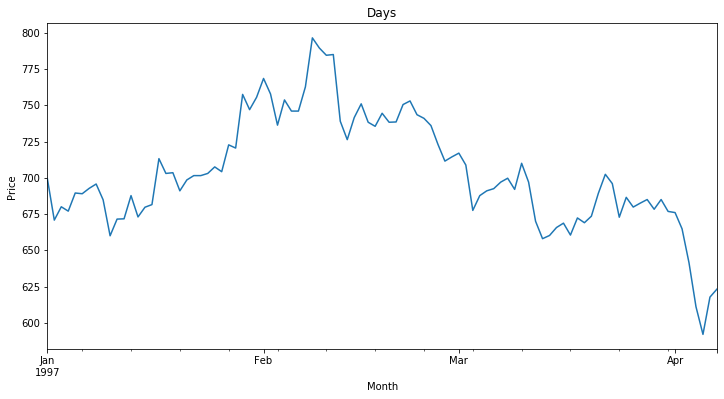

In [74]:
serie = serie.astype(float)
serie.plot(figsize=(V,H))
plt.title('Days')
plt.ylabel('Price')
plt.xlabel('Month')
plt.show()

In [0]:
def normalizar_serie(serie):
    minimo = min(serie)
    maximo = max(serie)
    y = (serie - minimo) / (maximo - minimo)
    return y
    
def desnormalizar(serie_atual, serie_real):
    minimo = min(serie_real)
    maximo = max(serie_real)
    
    serie = (serie_atual * (maximo - minimo)) + minimo
    
    return pd.DataFrame(serie)

In [0]:
serie_normalizada = normalizar_serie(serie)

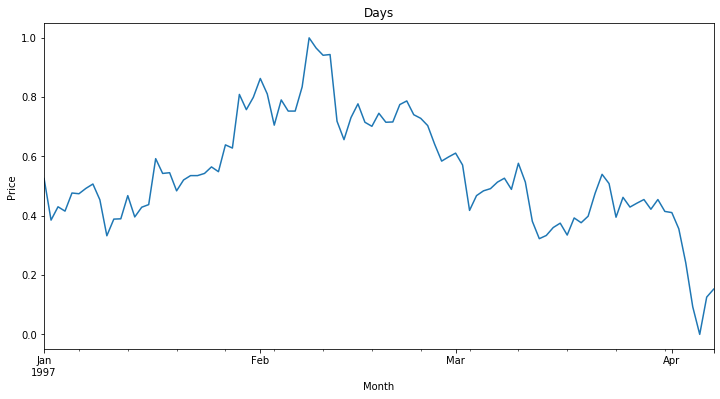

In [75]:
serie_normalizada.plot(figsize=(V,H))
plt.title('Days')
plt.ylabel('Price')
plt.xlabel('Month')
plt.show()

### Diff

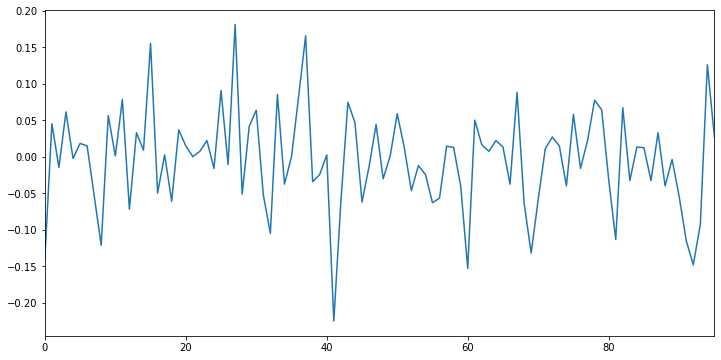

In [43]:
import numpy as np
s_diff = np.diff(serie_normalizada)
s_diff = pd.Series(s_diff)
s_diff.plot(figsize=(V,H))

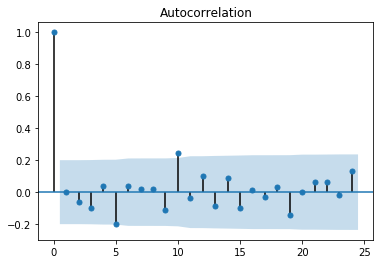

In [44]:
plot_acf(s_diff, lags=24)
plt.show()

## ACF

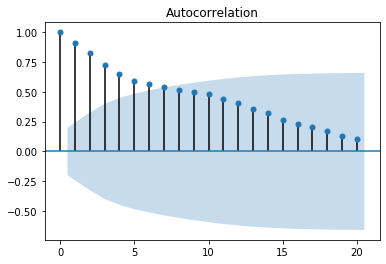

In [45]:
plot_acf(serie, lags=20)
plt.show()

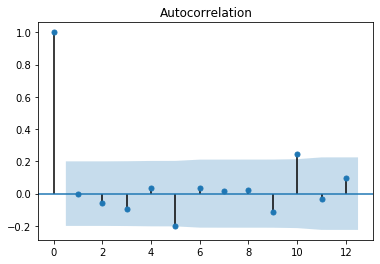

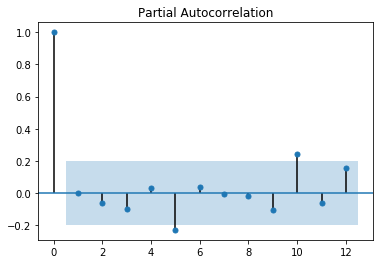

In [46]:
p = plot_acf(s_diff, lags=12)

p = plot_pacf(s_diff, lags=12)

## Seasonal decompose

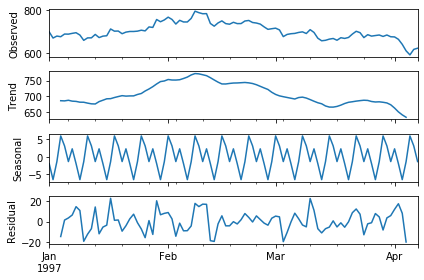

In [48]:
decompose = seasonal_decompose(serie, model='additive')
decompose.plot()
plt.show()

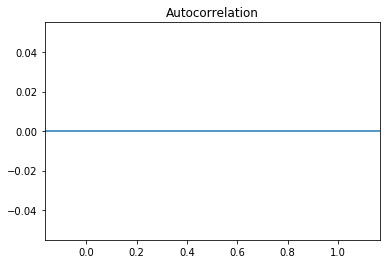

In [49]:
plot_acf(decompose.resid, lags=36)
plt.show()

## Data train and test

In [51]:
size = len(serie)
print(size)
l = int((7*size)/10)
print(l)

# original serie
serie_train = serie[:l]
serie_test = serie[l:]

size = len(s_diff)
print(size)
l = int((7*size)/10)
print(l)

# diff serie
s_diff_train = s_diff[:l]
s_diff_test = s_diff[l:]

97
67
96
67


## ARIMA

In [77]:
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = ARIMA(s_diff, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue
              
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: -240.16165 | order: (3, 0, 1)


In [78]:
# train ARIMA
model = ARIMA(s_diff_train, order=(3, 0, 1))
model_fitted = model.fit()

# parameters used
print("lags used: ", model_fitted.k_ar)
print("parameters: ", model_fitted.params)

lags used:  3
parameters:  const     -0.000247
ar.L1.y   -1.094507
ar.L2.y   -0.148934
ar.L3.y   -0.054242
ma.L1.y    1.000000
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


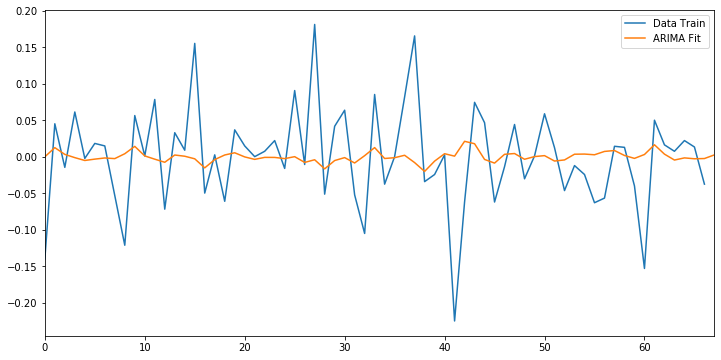

aic: -158.14877
MSE =  0.005550835166494622


In [79]:
plt.figure(figsize=(V,H))

# plot data train and test
s_diff_train.plot(label='Data Train')

#s_diff_test.plot(label='Data Test')

predict_train = model_fitted.predict(start=s_diff_train.index[0], end=len(s_diff_train), dynamic=False)
predict_train.plot(label='ARIMA Fit')

#predict = model_fitted.predict(start=s_diff_test.index[0], end=s_diff_test.index[-1], dynamic=False)
#predict.plot(label='ARIMA Forecasting')

#to show
plt.legend()
plt.show()

print('aic: {:6.5f}'.format(model_fitted.aic))

print('MSE = ', mean_squared_error(s_diff_train, predict_train[1:]))

In [55]:
print(model_fitted.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   67
Model:                     ARMA(3, 1)   Log Likelihood                  85.074
Method:                       css-mle   S.D. of innovations              0.068
Date:                Sun, 10 Nov 2019   AIC                           -158.149
Time:                        15:39:34   BIC                           -144.921
Sample:                             0   HQIC                          -152.914
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.007     -0.034      0.973      -0.014       0.014
ar.L1.y       -1.0945      0.124     -8.834      0.000      -1.337      -0.852
ar.L2.y       -0.1489      0.193     -0.774      0.4

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### Residuo

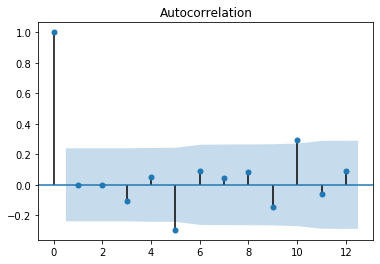

In [56]:
p = plot_acf(model_fitted.resid, lags=12)

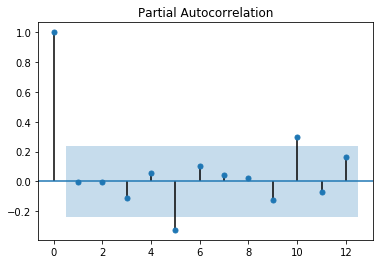

In [57]:
p = plot_pacf(model_fitted.resid, lags=12)

<Figure size 864x432 with 0 Axes>

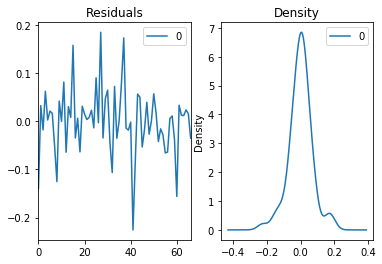

In [58]:
plt.figure(figsize=(V,H))

# Plot residual errors
residuals = pd.DataFrame(model_fitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# MLP

In [0]:
def gerar_janelas(tam_janela, serie):
    # serie: vetor do tipo numpy ou lista
    tam_serie = len(serie)
    tam_janela = tam_janela +1 # Adicionado mais um ponto para retornar o target na janela
    
    janela = list(serie[0:0+tam_janela]) #primeira janela p criar o objeto np
    janelas_np = np.array(np.transpose(janela))    
       
    for i in range(1, tam_serie-tam_janela):
        janela = list(serie[i:i+tam_janela])
        j_np = np.array(np.transpose(janela))        
        
        janelas_np = np.vstack((janelas_np, j_np))
        
    
    return janelas_np

In [80]:
qtd_lags = 3
janelas = gerar_janelas(qtd_lags, residuals.values)
janelas

array([[-1.40095429e-01,  3.26634937e-02, -1.77567145e-02,
         6.24783990e-02],
       [ 3.26634937e-02, -1.77567145e-02,  6.24783990e-02,
         2.80665977e-03],
       [-1.77567145e-02,  6.24783990e-02,  2.80665977e-03,
         2.14855369e-02],
       [ 6.24783990e-02,  2.80665977e-03,  2.14855369e-02,
         1.65078803e-02],
       [ 2.80665977e-03,  2.14855369e-02,  1.65078803e-02,
        -5.06214137e-02],
       [ 2.14855369e-02,  1.65078803e-02, -5.06214137e-02,
        -1.25259436e-01],
       [ 1.65078803e-02, -5.06214137e-02, -1.25259436e-01,
         4.21742742e-02],
       [-5.06214137e-02, -1.25259436e-01,  4.21742742e-02,
        -2.82665531e-05],
       [-1.25259436e-01,  4.21742742e-02, -2.82665531e-05,
         8.17028375e-02],
       [ 4.21742742e-02, -2.82665531e-05,  8.17028375e-02,
        -6.41806153e-02],
       [-2.82665531e-05,  8.17028375e-02, -6.41806153e-02,
         3.05340232e-02],
       [ 8.17028375e-02, -6.41806153e-02,  3.05340232e-02,
      

In [0]:
def split_serie_with_lags(serie, perc_train, perc_val = 0):
    
    #faz corte na serie com as janelas já formadas 
    
    x_date = serie[:, 0:-1]
    y_date = serie[:, -1]        
       
    train_size = np.fix(len(serie) *perc_train)
    train_size = train_size.astype(int)
    
    if perc_val > 0:        
        val_size = np.fix(len(serie) *perc_val).astype(int)
              
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]
        print("Particao de Treinamento:", 0, train_size  )
        
        x_val = x_date[train_size:train_size+val_size,:]
        y_val = y_date[train_size:train_size+val_size]
        
        print("Particao de Validacao:",train_size, train_size+val_size)
        
        x_test = x_date[(train_size+val_size):-1,:]
        y_test = y_date[(train_size+val_size):-1]
        
        print("Particao de Teste:", train_size+val_size, len(y_date))
        
        return x_train, y_train, x_test, y_test, x_val, y_val
        
    else:
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]

        x_test = x_date[train_size:-1,:]
        y_test = y_date[train_size:-1]

        return x_train, y_train, x_test, y_test

In [82]:
x_train, y_train, x_test, y_test, x_val, y_val = split_serie_with_lags(janelas, 0.70, perc_val = 0.15)

Particao de Treinamento: 0 44
Particao de Validacao: 44 53
Particao de Teste: 53 63


In [0]:
def treinar_mlp(x_train, y_train, x_val, y_val, num_exec):
    neuronios =  [10, 30, 50, 100, 200] 
    func_activation =  ['identity', 'tanh', 'relu']
    alg_treinamento = ['lbfgs', 'sgd', 'adam']
    max_iteracoes = [100, 1000, 10000]
    learning_rate = ['constant', 'invscaling', 'adaptive']
    best_result = np.Inf
    for i in range(0,len(neuronios)):
        for j in range(0,len(func_activation)):
            for l in range(0,len(alg_treinamento)):
                for m in range(0,len(max_iteracoes)):
                    for n in range(0,len(learning_rate)):  
                          print('Qtd de Neuronios' ,neuronios[i], 'Func. Act', func_activation[j])


                          for e in range(0,num_exec):
                              mlp = MLPRegressor(hidden_layer_sizes=neuronios[i], 
                                                 activation=func_activation[j], 
                                                 solver=alg_treinamento[l], 
                                                 max_iter = max_iteracoes[m], 
                                                 learning_rate=learning_rate[n])
                                
                                
                              mlp.fit(x_train, y_train)
                              predict_validation = mlp.predict(x_val)
                              mse = MSE(y_val, predict_validation)

                              if mse < best_result:
                                  best_result = mse
                                  print('Melhor MSE:', best_result)
                                  select_model = mlp    
    
    return select_model

In [84]:
modelo = treinar_mlp(x_train, y_train, x_val, y_val, 2)

Qtd de Neuronios 10 Func. Act identity
Melhor MSE: 0.0018983202221760553
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Melhor MSE: 0.0010567994359525759
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 10 Func. Act identity
Melhor MSE: 0.001014520997079582
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act identity
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Melhor MSE: 0.0009925918295858851
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act tanh
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Melhor MSE: 0.0009481451019825992
Qtd de Neuronios 10 Func. Act relu


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 10 Func. Act relu
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act identity
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Melhor MSE: 0.0008925695749957921
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act tanh
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 30 Func. Act relu
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act identity
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act tanh
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 50 Func. Act relu
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act iden

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act identity
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd 

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act tanh
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 100 Func. Act relu
Qtd de Neuronios 200 Func. Act identity
Qtd de Neuronios 200 Func. Act identity
Qtd de Neuronios 200 Func. Act identity
Qtd de Neuronios 200 Func. Act identity
Qtd de Neuronios 200 Func. Act identity
Qtd de Neuronios 200 Func. Act identity
Qtd de Neuronios 200 Func. Act identity
Qtd de Neuronios 200 Func. Act identity
Qtd de Neuronios 200 Func. Act identity
Qtd de Neuronios 200 Func. Act identity
Qtd de Neuronios 200 Func. Act identity
Qtd de Neuronios 200

## Test

In [0]:
predict_train = modelo.predict(x_train)
predict_val = modelo.predict(x_val)
predict_test = modelo.predict(x_test)

In [0]:
previsoes_train = np.hstack(( predict_train, predict_val))
target_train = np.hstack((y_train, y_val))

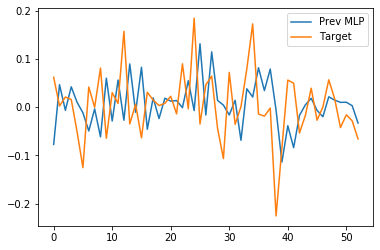

In [95]:
plt.plot(previsoes_train, label = 'Prev MLP')
plt.plot(target_train, label='Target')
plt.legend(loc='best')
plt.show()

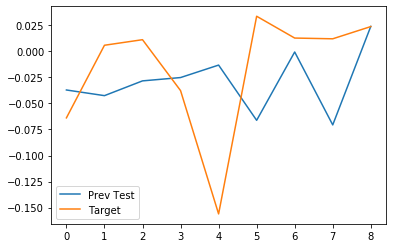

In [88]:
plt.plot(predict_test, label = 'Prev Test')
plt.plot(y_test, label='Target')
plt.legend(loc='best')
plt.show()

# ARIMA + MLP (residuo)

In [0]:
predict_train_arima = model_fitted.predict(start=s_diff_train.index[0], end=len(s_diff_train), dynamic=False)
predict_train_mlp = modelo.predict(np.concatenate((x_train, x_val, x_test)))

In [90]:
predict_train_arima

0    -0.000247
1     0.012324
2     0.003087
3    -0.001354
4    -0.005252
        ...   
63   -0.004657
64   -0.001713
65   -0.002904
66   -0.002588
67    0.002419
Length: 68, dtype: float64

In [91]:
len(predict_train_mlp)

62

In [0]:
predict_result = predict_train_arima[6:] + predict_train_mlp

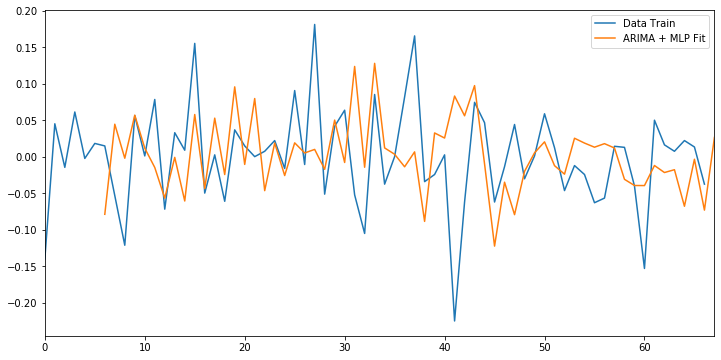

aic: -158.14877
MSE =  0.009732650233916328


In [94]:
plt.figure(figsize=(V,H))

# plot data train and test
s_diff_train.plot(label='Data Train')

predict_result.plot(label='ARIMA + MLP Fit')

#to show
plt.legend()
plt.show()

print('aic: {:6.5f}'.format(model_fitted.aic))

print('MSE = ', mean_squared_error(s_diff_train[6:], predict_result[1:]))